# Risk factors for disease severity in Papworth staff
- What demographic factors affect the severity of infection amongst seropositive staff?
- How do antibody responses differ within seropositive staff?
- Does it correlate with the severity of infection?

In [2]:
import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

%load_ext rpy2.ipython
from rpy2.robjects import r

In [4]:
%%R
packages <- c("ggplot2", "dplyr", "diosR", "plot.matrix", "broom", "dotwhisker", "MASS", "MuMIn", "VGAM", "effects", "pbkrtest")
lapply(packages, require, character.only=T)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] FALSE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] FALSE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] FALSE

[[10]]
[1] TRUE

[[11]]
[1] TRUE



In [5]:
os.chdir("/home/david/linux_work/coronavirus_2020/papworth/staff_analysis/data")

In [6]:
%%R
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /home/david/miniconda3/envs/HICC_datapipe/lib/libmkl_rt.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] pbkrtest_0.5-0.1  lme4_1.1-21       Matrix_1.2-17     effects_4.2-0    
 [5] carData_3.0-4     MuMIn_1.43.17     MASS_7.3-51.3     broom_0.5.2      
 [9] plot.matrix_1.5.2 dplyr_1.0.2       ggplot2_3.1.1    

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.5        nloptr_1.2.2.2    pillar_1.4.7      compiler_3.6.1   
 [5] plyr_1.8.

# Preprocessing

In [7]:
%%R
staf <- read.csv('staff_svm_demographic_antibodies.csv')

In [8]:
%%R
#Set missing sex data to NA
levels(staf$sex)[which(levels(staf$sex)=="")] <- NA
levels(staf$nep)[which(levels(staf$nep)=="")] <- NA

In [9]:
%%R
#Set severity, ethnicity, jobtype, and location to factors
staf$severity <- as.factor(staf$severity)
staf$ethnicity <- as.factor(staf$ethnicity)
# levels(staf$ethnicity) <- c('white', 'mixed', 'asian', 'black', 'other')
staf$jobtype <- as.factor(staf$jobtype)
staf$location <- as.factor(staf$location)

In [10]:
%%R
str(staf)

'data.frame':	500 obs. of  23 variables:
 $ id              : Factor w/ 500 levels "staff1","staff10",..: 1 112 223 334 445 457 479 468 490 2 ...
 $ laminar         : num  NA NA NA 2 NA NA NA NA NA NA ...
 $ age             : num  NA 42 NA 39 53 42 40 55 31 51 ...
 $ sex             : Factor w/ 2 levels "f","m": 2 1 1 1 2 1 1 2 2 2 ...
 $ severity        : Factor w/ 4 levels "1","2","3","4": 2 2 1 3 2 1 3 2 NA 1 ...
 $ ethnicity       : Factor w/ 5 levels "1","2","3","4",..: 3 1 1 1 1 1 3 1 1 1 ...
 $ jobtype         : Factor w/ 2 levels "1","2": 1 1 1 1 1 1 1 1 1 1 ...
 $ location        : Factor w/ 3 levels "1","2","3": 1 2 2 2 2 2 3 2 2 2 ...
 $ note            : Factor w/ 2 levels ""," (re-assigned at sampling from 110)": 1 1 1 1 1 1 1 1 1 1 ...
 $ BOOKED.ON.EPIC  : Factor w/ 2 levels "","Y": 2 2 2 2 2 2 2 2 2 2 ...
 $ DATE.TESTED     : Factor w/ 19 levels "","01/05/2020",..: 12 10 10 10 10 10 10 18 19 19 ...
 $ BATCH           : Factor w/ 24 levels "","ICDV3","ICDV9",..: 6 16 16 1

In [11]:
%%R
#Remove samples with any missing data
stafn <- staf[!is.na(staf$severity) & !is.na(staf$age) & !is.na(staf$sex),]

In [12]:
%%R
#We are only interested in severity amongst SerO Positive samples
sop <- filter(stafn, sero_svm==1)

#Merge severity 3 and 4 because there is only one case of 4.
sop$severity3 <- sop$severity
sop$severity3[sop$severity == 4] <- 3
sop$severity3 <- ordered(sop$severity3)

sop$diseased <- sop$severity != 1

In [13]:
%%R
# Effects due to coronavirus infection should not be observed in seronegative samples
#SerONegative cases
son <- filter(stafn, sero_svm==0)

#Merge severity 3 and 4 because there is only one case of 4.
son$severity3 <- son$severity
son$severity3[son$severity == 4] <- 3
son$severity3 <- ordered(son$severity3)

son$diseased <- son$severity != 1

# Exploration plots
Age, sex and ethnicity are the three demographic variables to consider.

In [14]:
%%R
table(sop$sex)


 f  m 
45 16 


In [15]:
%%R
table(sop$sex, sop$severity)

   
     1  2  3  4
  f 14 28  3  0
  m  4  5  6  1


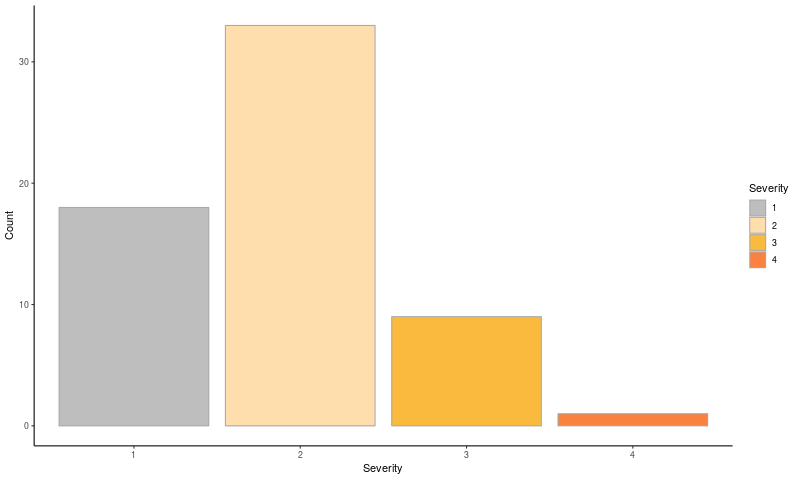

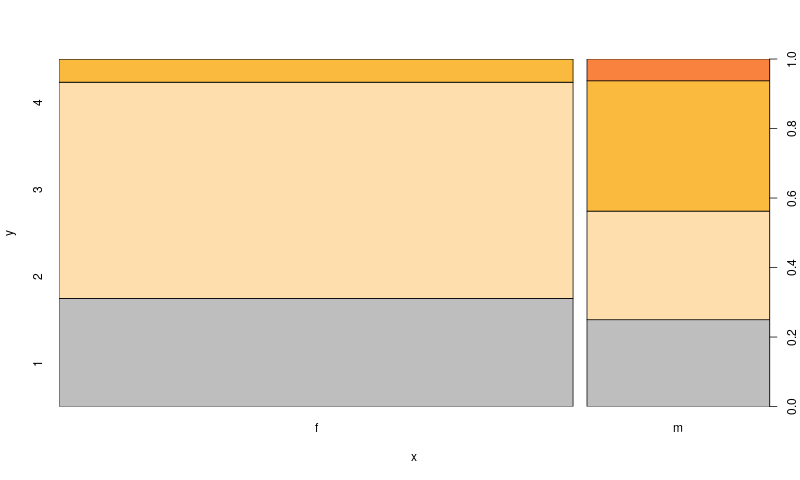

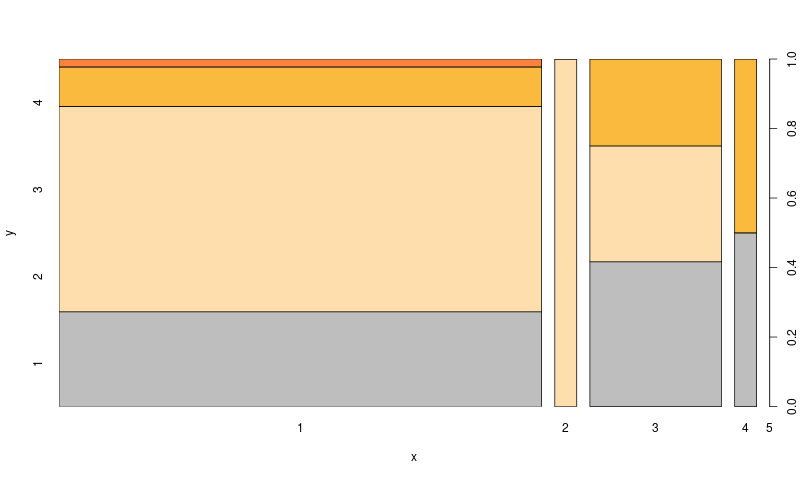

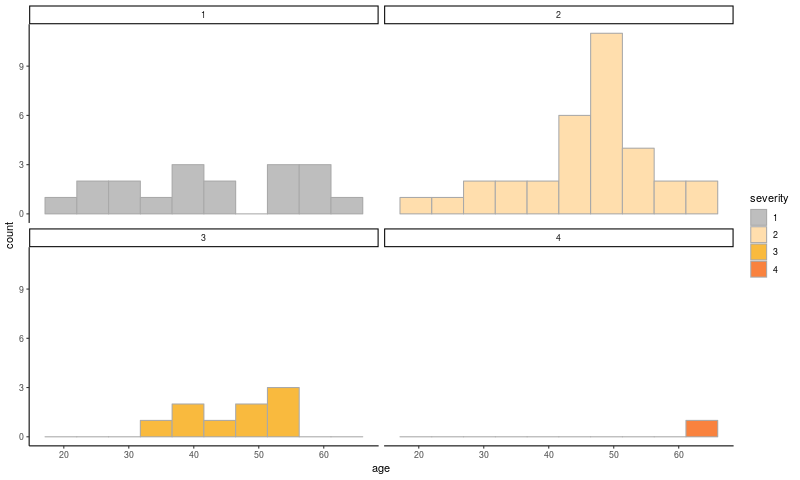

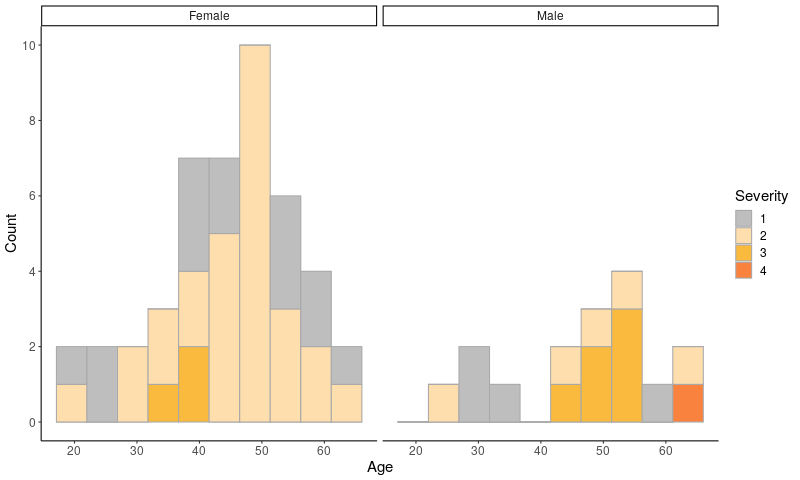

In [16]:
%%R -w 800

#SEVerity PALette
sev_pal <- c("grey", "navajowhite", "#F9BA3E", "#F9823E")

print(ggplot(sop, aes(x=severity, fill=severity))+
geom_bar(colour="darkgrey")+
scale_fill_manual(values=sev_pal)+
xlab("Severity")+
ylab("Count")+
guides(fill=guide_legend(title="Severity"))+
# theme_dios()
theme_classic()
)

plot(sop$sex, sop$severity, col=sev_pal)

plot(sop$ethnicity, sop$severity, col=sev_pal)

print(ggplot(sop, aes(x=age, fill=severity))+
geom_histogram(bins=10, colour="darkgrey")+
facet_wrap(.~severity)+
scale_fill_manual(values=sev_pal)+
# theme_dios()
theme_classic()
)

sex_labeller <- function(variable, value){
    sex_labels <- list("f"="Female", "m"="Male")
    return(sex_labels[value])
}

fig <- 
ggplot(sop, aes(x=age, fill=severity))+
geom_histogram(bins=10, colour="darkgrey")+
facet_wrap(.~sex, labeller=sex_labeller)+
scale_fill_manual(values=sev_pal)+
xlab("Age")+
ylab("Count")+
guides(fill=guide_legend(title="Severity"))+
scale_y_continuous(breaks=c(seq(0,10,2)))+
theme_classic()+
theme(text=element_text(size=15))

print(fig)

In [20]:
%%R
ggsave("figure4a.jpg", fig, dpi=300, units="in", width=8, height=5)
write.csv(sop, "seropositive_samples_histogram.csv", row.names=F)

In [25]:
%%R
ggplot(stafn, aes(x=severity, fill=severity))+
geom_bar(colour="darkgrey")+
facet_wrap(.~sero_svm)+
scale_fill_manual(values=sev_pal)+
xlab("Severity")+
ylab("Count")+
guides(fill=guide_legend(title="Severity"))+
# theme_dios()
theme_classic()

table(stafn$sero_svm, stafn$severity)

   
      1   2   3   4
  0 232 140  16   0
  1  18  33   9   1


# Fit models

In [26]:
%%R
m0 <- polr(severity3 ~ 1, data=sop, Hess=T)
m1 <- polr(severity3 ~ age, data=sop, Hess=T)
m2 <- polr(severity3 ~ sex, data=sop, Hess=T)
m3 <- polr(severity3 ~ age + sex, data=sop, Hess=T)
m4 <- polr(severity3 ~ age * sex, data=sop, Hess=T)

aicc <- function(m){
    k <- m$edf
    AIC(m) + ((2*k**2+2*k)/(m$n-k-1))
}

print(AIC(m0, m1, m2, m3, m4))
print(c(aicc(m0), aicc(m1), aicc(m2), aicc(m3), aicc(m4)))
Weights(c(aicc(m0), aicc(m1), aicc(m2), aicc(m3), aicc(m4)))

   df      AIC
m0  2 124.6520
m1  3 124.8375
m2  3 121.6410
m3  4 122.1578
m4  5 118.4226
[1] 124.8589 125.2586 122.0620 122.8721 119.5135
 model weights 
[1] 0.043 0.036 0.176 0.117 0.628


In [27]:
%%R
summary(as.factor(as.data.frame(model.matrix(m4))$sex))

 0  1 
45 16 


In [28]:
%%R
anova(m4, m3, test="Chisq")

Likelihood ratio tests of ordinal regression models

Response: severity3
      Model Resid. df Resid. Dev   Test    Df LR stat.   Pr(Chi)
1 age + sex        57   114.1578                                
2 age * sex        56   108.4226 1 vs 2     1 5.735282 0.0166274


In [29]:
%%R
(2*logLik(m4))-(2*logLik(m3))

'log Lik.' 5.735282 (df=5)


In [30]:
%%R
summary(m4)

Call:
polr(formula = severity3 ~ age * sex, data = sop, Hess = T)

Coefficients:
             Value Std. Error t value
age      -0.003358    0.02680 -0.1253
sexm     -4.529895    2.56150 -1.7685
age:sexm  0.128700    0.05586  2.3039

Intercepts:
    Value   Std. Error t value
1|2 -0.8542  1.2513    -0.6827
2|3  2.1148  1.2956     1.6323

Residual Deviance: 108.4226 
AIC: 118.4226 


In [31]:
%%R
#Generate data for predictions
n <- 100
age <- seq(min(sop$age), max(sop$age), length.out=n)
sex <- c("f", "m")

nd <- expand.grid(age=age, sex=sex)
nd <- cbind(nd, predict(m4, type="probs", newdata=nd))
names(nd)[match(1:3, names(nd))] <- paste0("Severity", 1:3)

In [32]:
# %%R -w 800

# sex_labeller <- function(variable, value){
#     sex_labels <- list("f"="Female", "m"="Male")
#     return(sex_labels[value])
# }

# ggplot(nd, aes(x=age, y=Severity1, lty=sex))+
# geom_line(size=3)+
# geom_line(aes(y=Severity2), size=3, colour = "navajowhite")+
# geom_line(aes(y=Severity3), size=3, colour = "orange")+
# facet_wrap(.~sex, labeller=sex_labeller)+
# guides(lty=F)+
# xlab("Age")+
# ylab("Probability of severity class")+
# theme_dios()

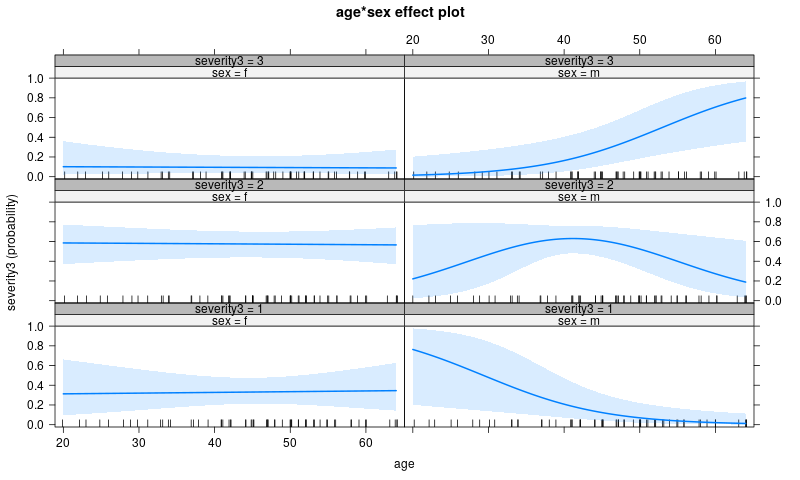

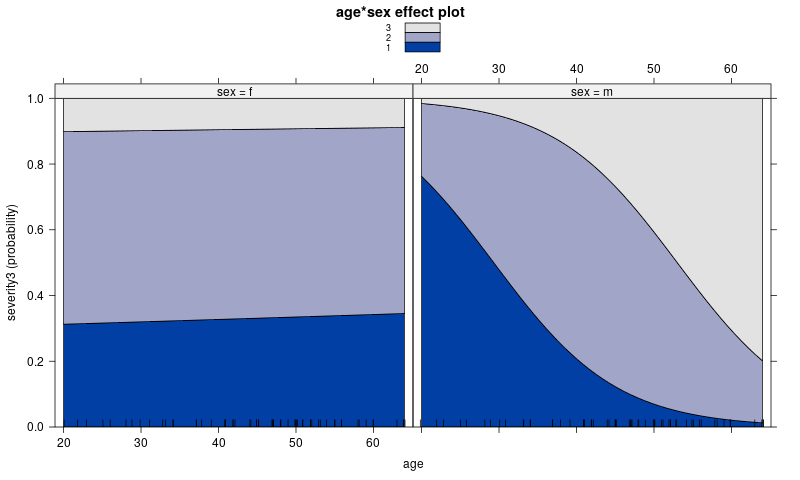

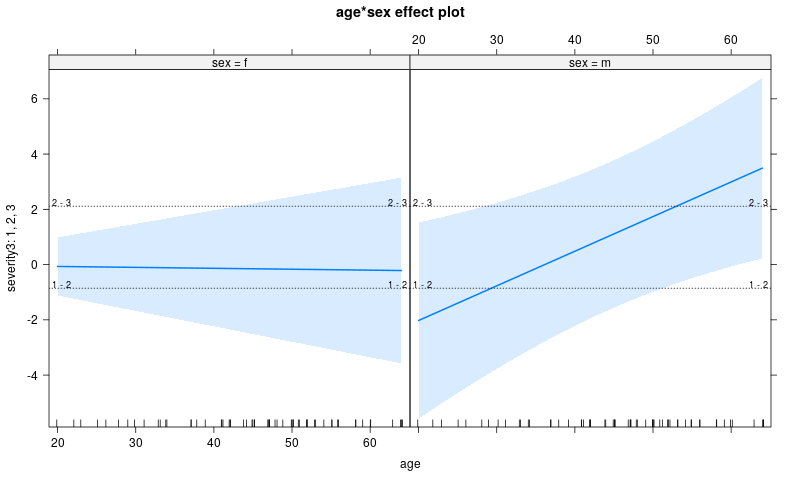

In [33]:
%%R -w 800
print(plot(effect("age*sex", m4, xlevels=50)))
print(plot(effect("age*sex", m4, xlevels=50), style="stacked"))
print(plot(effect("age*sex", m4, xlevels=50, latent=T)))

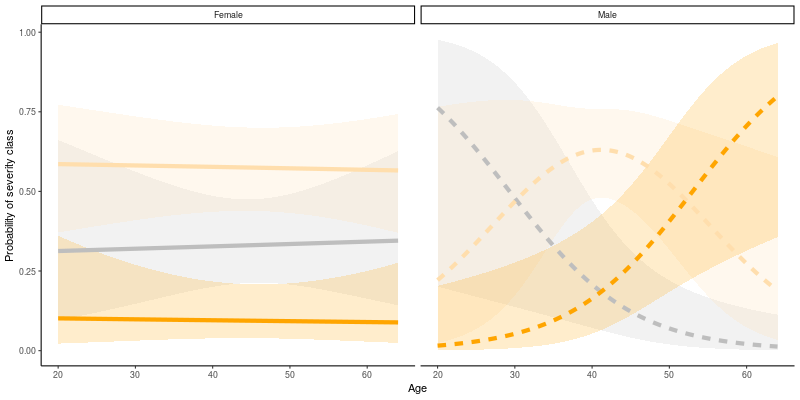

In [43]:
%%R -w 800 -h 400
#m4 effects
m4f <- effect("age*sex", m4, xlevels=1000)

nd <- cbind(
    m4f$x,
    m4f$prob,
    m4f$lower.prob,
    m4f$upper.prob
)

fig <- 
ggplot(nd, aes(x=age, y=prob.X1, lty=sex))+
geom_ribbon(aes(ymin=L.prob.X1, ymax=U.prob.X1), alpha=0.2, fill="grey")+
geom_ribbon(aes(ymin=L.prob.X2, ymax=U.prob.X2), alpha=0.2, fill="navajowhite")+
geom_ribbon(aes(ymin=L.prob.X3, ymax=U.prob.X3), alpha=0.2, fill="orange")+
geom_line(size=2, colour="grey")+
geom_line(aes(y=prob.X2), size=2, colour = "navajowhite")+
geom_line(aes(y=prob.X3), size=2, colour = "orange")+
facet_wrap(.~sex, labeller=sex_labeller)+
guides(lty=F)+
xlab("Age")+
ylab("Probability of severity class")+
# theme_dios()
theme_classic()

fig

In [44]:
%%R
# ggsave("figure4b.jpg", fig, dpi=300, units="in", width=8, height=5)

### Assumption of proportional odds

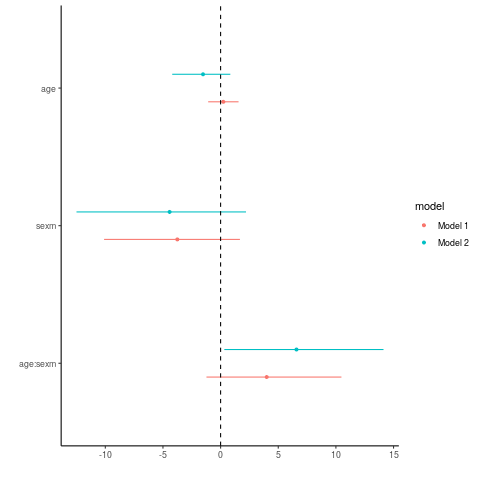

In [22]:
%%R
m4a <- glm(I(as.numeric(severity3)>=2) ~ age*sex, family="binomial", data=sop)
m4b <- glm(I(as.numeric(severity3)>=3) ~ age*sex, family="binomial", data=sop)

#Note that dwplot() doesn't seem to have the correct magnitude of the effects
dwplot(list(m4a, m4b)) +
geom_vline(xintercept=0, lty=2)+
theme_classic()

It appears that age has a very different effect on severity in men and women. However, the number of men in the sample is really quite low.

### Women only models

In [23]:
%%R
mf0 <- polr(severity3 ~ 1, data=filter(sop, sex=="f"), Hess=T)
mf1 <- polr(severity3 ~ age, data=filter(sop, sex=="f"), Hess=T)

print(AIC(mf0, mf1))
Weights(AIC(mf0, mf1))
anova(mf0,mf1, test="Chisq")

    df      AIC
mf0  2 79.51089
mf1  3 81.49288
Likelihood ratio tests of ordinal regression models

Response: severity3
  Model Resid. df Resid. Dev   Test    Df   LR stat.  Pr(Chi)
1     1        43   75.51089                                 
2   age        42   75.49288 1 vs 2     1 0.01801724 0.893222


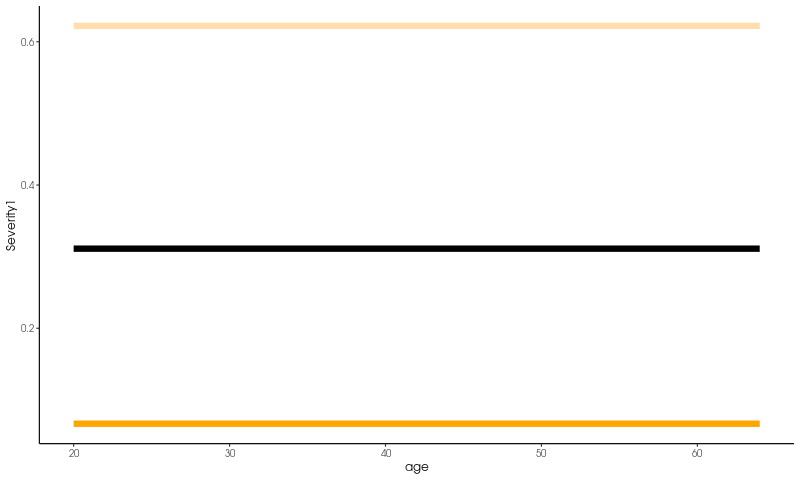

In [24]:
%%R -w 800

#Generate data for predictions
n <- 100
nd <- data.frame(age = seq(min(sop$age), max(sop$age), length.out=n))

nd <- cbind(nd, predict(mf0, type="probs", newdata=nd))
names(nd)[match(1:3, names(nd))] <- paste0("Severity", 1:3)

ggplot(nd, aes(x=age, y=Severity1))+
geom_line(size=3)+
geom_line(aes(y=Severity2), size=3, colour = "navajowhite")+
geom_line(aes(y=Severity3), size=3, colour = "orange")+
theme_dios()

### A symptomatic vs diseased

In [25]:
# %%R
# d0 <- glm(diseased ~ 1, data=sop, family="binomial")
# d1 <- glm(diseased ~ age, data=sop, family="binomial")
# d2 <- glm(diseased ~ sex, data=sop, family="binomial")
# d3 <- glm(diseased ~ age + sex, data=sop, family="binomial")
# d4 <- glm(diseased ~ age * sex, data=sop, family="binomial")

# print(MuMIn::AICc(d0,d1,d2,d3,d4))
# Weights(MuMIn::AICc(d0,d1,d2,d3,d4))

In [26]:
# %%R
# print(summary(d4))
# dwplot(d4) + 
# geom_vline(xintercept=0, lty=2)+
# theme_dios()

In [27]:
# %%R -w 800

# #Generate data for predictions
# n <- 10
# age <- seq(min(sop$age), max(sop$age), length.out=n)
# sex <- c("f", "m")

# nd <- expand.grid(age=age, sex=sex)
# nd <- cbind(nd, predict(d4, newdata=nd, type="response", se.fit=T))
# names(nd)[3] <- "pred"

# ggplot(nd, aes(x=age, y=pred, colour=sex, fill=sex))+
# geom_line(size=3)+
# geom_ribbon(aes(ymin=pred-(1.96*se.fit), ymax=pred+(1.96*se.fit)), alpha=0.3)+
# theme_dios()

In [28]:
# %%R -w 800

# #Generate data for predictions
# n <- 10
# age <- seq(min(sop$age), max(sop$age), length.out=n)
# sex <- c("f", "m")

# nd <- expand.grid(age=age, sex=sex)
# nd <- cbind(nd, predict(d4, newdata=nd, type="link", se.fit=T))
# names(nd)[3] <- "pred"

# ggplot(nd, aes(x=age, y=pred, colour=sex, fill=sex))+
# geom_line(size=3)+
# geom_ribbon(aes(ymin=pred-(1.96*se.fit), ymax=pred+(1.96*se.fit)), alpha=0.3)+
# theme_dios()

In [29]:
# %%R
# #model.matrix(terms(d4), nd)
# mm <- model.matrix(delete.response(terms(d4)), nd)
# # mm %*% fix
# #Predictions
# mm %*% coef(d4)
# #prediction variance
# predvar <- diag(mm %*% vcov(d4) %*% t(mm))
# sqrt(predvar)

In [30]:
# %%R
# predict(d4,newdata=nd, se.fit=T)

In [31]:
# %%R
# v0 <- vglm(severity3 ~ 1, data=sop, family=propodds)
# v1 <- vglm(severity3 ~ age, data=sop, family=propodds)
# v2 <- vglm(severity3 ~ sex, data=sop, family=propodds)
# v3 <- vglm(severity3 ~ age + sex, data=sop, family=propodds)
# v4 <- vglm(severity3 ~ age * sex, data=sop, family=propodds)

# print(sapply(c(v0,v1,v2,v3,v4), AICc))
# Weights(sapply(c(v0,v1,v2,v3,v4), AICc))

In [32]:
# %%R
# drop1(v4, test="LRT")

In [33]:
# %%R
# summary(v4)

In [34]:
# %%R
# #Generate data for predictions
# n <- 100
# age <- seq(min(sop$age), max(sop$age), length.out=n)
# sex <- c("f", "m")

# nd <- expand.grid(age=age, sex=sex)
# nd <- cbind(nd, predict(v4, type="response", newdata=nd))
# names(nd)[match(1:3, names(nd))] <- paste0("Severity", 1:3)

In [35]:
# %%R -w 800

# sex_labeller <- function(variable, value){
#     sex_labels <- list("f"="Female", "m"="Male")
#     return(sex_labels[value])
# }

# ggplot(nd, aes(x=age, y=Severity1, lty=sex))+
# geom_line(size=3)+
# geom_line(aes(y=Severity2), size=3, colour = "navajowhite")+
# geom_line(aes(y=Severity3), size=3, colour = "orange")+
# facet_wrap(.~sex, labeller=sex_labeller)+
# guides(lty=F)+
# xlab("Age")+
# ylab("Probability of severity class")+
# theme_dios()

In [36]:
# %%R
# #Generate data for predicting cumulative probability
# n <- 100
# age <- seq(min(sop$age), max(sop$age), length.out=n)
# sex <- c("f", "m")

# nd <- expand.grid(age=age, sex=sex)
# nd <- cbind(nd, predict(v4, type="link", newdata=nd))
# se <- predict(v4, type="link", newdata=nd, se.fit=T)$se.fit

# #Cumulative log odds ratio of severity x or greater
# names(nd)[match(c('logitlink(P[Y>=2])', 'logitlink(P[Y>=3])'), names(nd))] <- paste0("CLORseverity", 2:3)

# #Calculate the cumulative probability of being severity x or higher
# nd$Cseverity3 <- plogis(nd$CLORseverity3)
# nd$Cseverity2 <- plogis(nd$CLORseverity2)

# head(nd)

In [37]:
# %%R
# #Calculate upper and lower 95% confidence intervals
# # for Cumulative log odds ratios
# nd$CLORseverity3U <- nd$CLORseverity3 + (1.96*se[,'logitlink(P[Y>=3])'])
# nd$CLORseverity3L <- nd$CLORseverity3 - (1.96*se[,'logitlink(P[Y>=3])'])

# nd$CLORseverity2U <- nd$CLORseverity2 + (1.96*se[,'logitlink(P[Y>=2])'])
# nd$CLORseverity2L <- nd$CLORseverity2 - (1.96*se[,'logitlink(P[Y>=2])'])


# #Convert from cumulative log odds ratios to cumulative probabilities
# nd$Cseverity3U <- plogis(nd$CLORseverity3U)
# nd$Cseverity3L <- plogis(nd$CLORseverity3L)

# nd$Cseverity2U <- plogis(nd$CLORseverity2U)
# nd$Cseverity2L <- plogis(nd$CLORseverity2L)

In [38]:
# %%R -w 800

# sex_labeller <- function(variable, value){
#     sex_labels <- list("f"="Female", "m"="Male")
#     return(sex_labels[value])
# }

# ggplot(nd, aes(x=age, y=1, lty=sex))+
# geom_line(size=3)+
# geom_line(aes(y=Cseverity2), size=3, colour = "navajowhite")+
# geom_line(aes(y=Cseverity3), size=3, colour = "orange")+
# geom_ribbon(aes(ymin=Cseverity2L, ymax=Cseverity2U), alpha=0.3, fill="navajowhite")+
# geom_ribbon(aes(ymin=Cseverity3L, ymax=Cseverity3U), alpha=0.3, fill="orange")+
# facet_wrap(.~sex, labeller=sex_labeller)+
# guides(lty=F)+
# xlab("Age")+
# ylab("Cumulative probability of severity class")+
# theme_dios()

In [39]:
# %%R
# #Convert to probablity
# # not sure this is allowed
# nd$severity3 <- nd$Cseverity3
# nd$severity2 <- nd$Cseverity2 - nd$Cseverity3
# nd$severity1 <- 1 - nd$Cseverity2

# nd$severity3L <- nd$Cseverity3L
# nd$severity3U <- nd$Cseverity3U

# nd$severity2L <- nd$Cseverity2L
# nd$severity2U <- nd$Cseverity2U


In [40]:
# %%R -w 800
# ggplot(nd, aes(x=age, y=severity1, lty=sex))+
# geom_line(size=3)+
# geom_line(aes(y=severity2), size=3, colour = "navajowhite")+
# geom_line(aes(y=severity3), size=3, colour = "orange")+
# # geom_ribbon(aes(ymin=Cseverity2L, ymax=Cseverity2U), alpha=0.3, fill="navajowhite")+
# geom_ribbon(aes(ymin=severity3L, ymax=severity3U), alpha=0.3, fill="orange")+
# facet_wrap(.~sex, labeller=sex_labeller)+
# guides(lty=F)+
# xlab("Age")+
# ylab("Cumulative probability of severity class")+
# theme_dios()

In [41]:
# %%R -w 800

# sex_labeller <- function(variable, value){
#     sex_labels <- list("f"="Female", "m"="Male")
#     return(sex_labels[value])
# }

# ggplot(nd, aes(x=age, y=Cseverity1, lty=sex))+
# geom_line(size=3)+
# geom_line(aes(y=Cseverity2), size=3, colour = "navajowhite")+
# geom_line(aes(y=Cseverity3), size=3, colour = "orange")+
# facet_wrap(.~sex, labeller=sex_labeller)+
# guides(lty=F)+
# xlab("Age")+
# ylab("Cumulative probability of severity class")+
# theme_dios()

## Add ethnicity

In [14]:
%%R
e4 <- polr(severity3 ~ age * sex, data=filter(sop, ethnicity%in%c(1,3)), Hess=T)
e5 <- polr(severity3 ~ age * sex + ethnicity, data=filter(sop, ethnicity%in%c(1,3)), Hess=T)

aicc <- function(m){
    k <- m$edf
    AIC(m) + ((2*k**2+2*k)/(m$n-k-1))
}

# print(AIC(e4, e5))
print(c(aicc(e4), aicc(e5)))
Weights(c(aicc(e4), aicc(e5)))


Error in filter(sop, ethnicity %in% c(1, 3)) : object 'sop' not found


/home/david/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in filter(sop, ethnicity %in% c(1, 3)) : object 'sop' not found

  warnings.warn(x, RRuntimeWarning)


In [43]:
%%R
summary(e5)

Call:
polr(formula = severity3 ~ age * sex + ethnicity, data = filter(sop, 
    ethnicity %in% c(1, 3)), Hess = T)

Coefficients:
               Value Std. Error t value
age        -0.007391    0.02845 -0.2598
sexm       -7.003354    3.02546 -2.3148
ethnicity3 -1.026787    0.72410 -1.4180
age:sexm    0.199222    0.06975  2.8561

Intercepts:
    Value   Std. Error t value
1|2 -1.1747  1.3431    -0.8746
2|3  2.0588  1.3866     1.4848

Residual Deviance: 92.91782 
AIC: 104.9178 


In [44]:
%%R -w 800 -h 400
summary(m4)

Call:
polr(formula = severity3 ~ age * sex, data = sop, Hess = T)

Coefficients:
             Value Std. Error t value
age      -0.003358    0.02680 -0.1253
sexm     -4.529895    2.56150 -1.7685
age:sexm  0.128700    0.05586  2.3039

Intercepts:
    Value   Std. Error t value
1|2 -0.8542  1.2513    -0.6827
2|3  2.1148  1.2956     1.6323

Residual Deviance: 108.4226 
AIC: 118.4226 


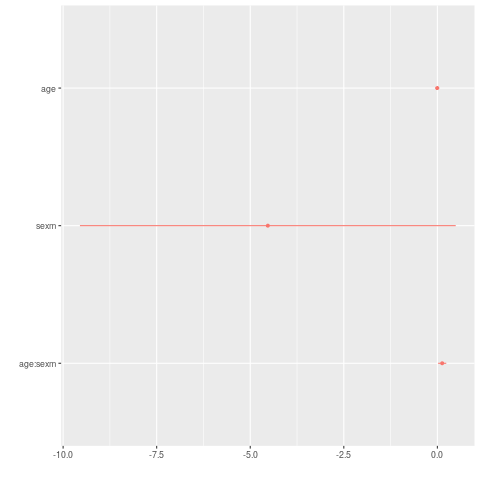

In [45]:
%%R
dwplot(tidy(m4))

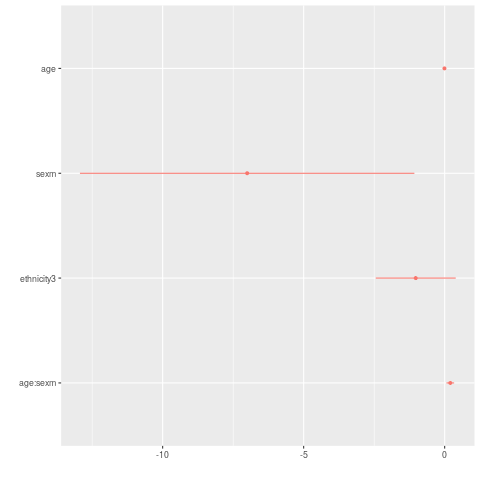

In [46]:
%%R
dwplot(tidy(e5))

## Effects in seronegative cases
We should see no such sex\*age affects in the seronegative staff.

In [24]:
%%R
m0 <- polr(severity3 ~ 1, data=son, Hess=T)
m1 <- polr(severity3 ~ age, data=son, Hess=T)
m2 <- polr(severity3 ~ sex, data=son, Hess=T)
m3 <- polr(severity3 ~ age + sex, data=son, Hess=T)
m4 <- polr(severity3 ~ age * sex, data=son, Hess=T)

aicc <- function(m){
    k <- m$edf
    AIC(m) + ((2*k**2+2*k)/(m$n-k-1))
}

print(AIC(m0, m1, m2, m3, m4))
print(c(aicc(m0), aicc(m1), aicc(m2), aicc(m3), aicc(m4)))
Weights(c(aicc(m0), aicc(m1), aicc(m2), aicc(m3), aicc(m4)))

   df      AIC
m0  2 630.0713
m1  3 630.6998
m2  3 631.3276
m3  4 631.8027
m4  5 633.5605
[1] 630.1025 630.7623 631.3901 631.9072 633.7176
 model weights 
[1] 0.355 0.256 0.187 0.144 0.058


# To do


In [31]:
%%R
citation("MASS")
citation("effects")
citation("pbkrtest")


To cite pbkrtest in publications use:

  Ulrich Halekoh, Søren Højsgaard (2014). A Kenward-Roger Approximation
  and Parametric Bootstrap Methods for Tests in Linear Mixed Models -
  The R Package pbkrtest. Journal of Statistical Software, 59(9), 1-30.
  URL http://www.jstatsoft.org/v59/i09/.

A BibTeX entry for LaTeX users is

  @Article{,
    title = {A Kenward-Roger Approximation and Parametric Bootstrap Methods for Tests in Linear Mixed Models -- The {R} Package {pbkrtest}},
    author = {Ulrich Halekoh and S{\o}ren H{\o}jsgaard},
    journal = {Journal of Statistical Software},
    year = {2014},
    volume = {59},
    number = {9},
    pages = {1--30},
    url = {http://www.jstatsoft.org/v59/i09/},
  }



Benjamini, Yoav, and Yosef Hochberg. "Controlling the false discovery rate: a practical and powerful approach to multiple testing." Journal of the Royal statistical society: series B (Methodological) 57, no. 1 (1995): 289-300.